In [1]:
# Setup
import pandas as pd
import numpy as np

import math
import requests
from bs4 import BeautifulSoup

import re
import dateutil.parser
from pprint import pprint
import pickle

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

%matplotlib inline

from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read in data
data = pd.read_csv('cleaned_movie_data.csv')

In [3]:
data.head()

,domestic_total_gross,log_dtg,budget,runtime_min,year,winter,spring,summer,fall,G,NC-17,PG,PG-13,R,winning_director,log_budget,release_date,title,director,genre
0,223808164.0,19.226300,180000000.0,97.0,2008,0,0,1,0,1,0,0,0,0,0,19.008467,2008-06-27,WALL-E,Andrew Stanton,"['animated', 'sci-fi', 'adventure', 'sci-fi']"
1,222527828.0,19.220563,165000000.0,108.0,2014,0,0,0,1,0,0,1,0,0,0,18.921456,2014-11-07,Big Hero 6,Don Hall,"['animated', 'sci-fi', '3D', 'adapted from a c..."
2,198351526.0,19.105551,175000000.0,94.0,2009,0,1,0,0,0,0,1,0,0,0,18.980297,2009-03-27,Monsters Vs. Aliens,Rob Letterman,"['animated', 'sci-fi', 'alien invasion', 'sci-..."
3,177397510.0,18.993904,135000000.0,94.0,2015,0,1,0,0,0,0,1,0,0,0,18.720785,2015-03-27,Home,Tim Johnson,[]
4,145794338.0,18.797708,80000000.0,85.0,2002,0,0,1,0,0,0,1,0,0,0,18.197537,2002-06-21,Lilo & Stitch,Dean DeBlois,"['animated', 'sci-fi']"


In [4]:
data.shape

(540, 20)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 20 columns):
domestic_total_gross    540 non-null float64
log_dtg                 540 non-null float64
budget                  540 non-null float64
runtime_min             540 non-null float64
year                    540 non-null int64
winter                  540 non-null int64
spring                  540 non-null int64
summer                  540 non-null int64
fall                    540 non-null int64
G                       540 non-null int64
NC-17                   540 non-null int64
PG                      540 non-null int64
PG-13                   540 non-null int64
R                       540 non-null int64
winning_director        540 non-null int64
log_budget              540 non-null float64
release_date            540 non-null object
title                   540 non-null object
director                540 non-null object
genre                   540 non-null object
dtypes: float64(5), i

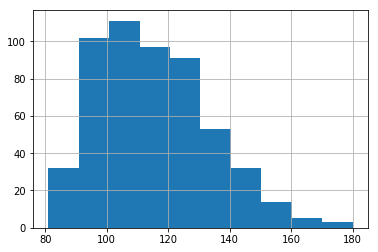

In [6]:
# Look at the runtime_min feature distribution
data.runtime_min.hist()

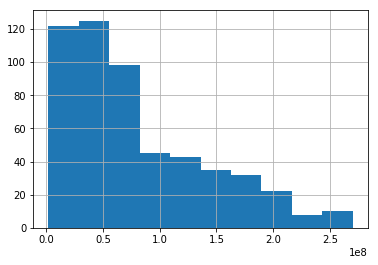

In [7]:
# Look at the budget feature distribution
data.budget.hist()

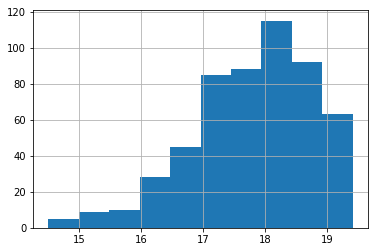

In [8]:
# Log budget feature
data['log_budget'] = np.log(data.budget)

# Does it look better?
data.log_budget.hist()

In [9]:
# Look at correlations
data.corr()

,domestic_total_gross,log_dtg,budget,runtime_min,year,winter,spring,summer,fall,G,NC-17,PG,PG-13,R,winning_director,log_budget
domestic_total_gross,1.000000,0.812533,0.658019,0.292493,0.168544,-0.104480,0.145000,0.133177,-0.189325,0.036666,-0.070262,0.117782,0.229187,-0.343624,-0.033078,0.564277
log_dtg,0.812533,1.000000,0.631096,0.271143,0.105778,-0.095248,0.156078,0.181974,-0.261998,0.048395,-0.150986,0.138165,0.262161,-0.386238,-0.053446,0.634704
budget,0.658019,0.631096,1.000000,0.339897,0.327867,-0.164858,0.181393,0.126656,-0.161226,0.048834,-0.069152,0.041262,0.321840,-0.383908,-0.111135,0.888671
runtime_min,0.292493,0.271143,0.339897,1.000000,-0.038486,0.006684,0.045510,-0.081691,0.037584,-0.048446,0.023514,-0.241262,0.125232,0.072993,0.101953,0.278591
year,0.168544,0.105778,0.327867,-0.038486,1.000000,-0.010217,0.043175,-0.014111,-0.017633,-0.060984,-0.044489,-0.052288,0.131648,-0.076054,-0.237498,0.257982
winter,-0.104480,-0.095248,-0.164858,0.006684,-0.010217,1.000000,-0.280620,-0.347755,-0.287877,-0.024445,-0.038019,-0.044748,-0.015379,0.066155,-0.011564,-0.121716
spring,0.145000,0.156078,0.181393,0.045510,0.043175,-0.280620,1.000000,-0.377160,-0.312219,0.004832,-0.041234,0.132843,-0.044373,-0.056523,-0.046206,0.141282
summer,0.133177,0.181974,0.126656,-0.081691,-0.014111,-0.347755,-0.377160,1.000000,-0.386914,0.047767,-0.051099,-0.026799,0.129386,-0.122055,-0.047417,0.148715
fall,-0.189325,-0.261998,-0.161226,0.037584,-0.017633,-0.287877,-0.312219,-0.386914,1.000000,-0.033641,0.132069,-0.059763,-0.082349,0.126067,0.108032,-0.186295
G,0.036666,0.048395,0.048834,-0.048446,-0.060984,-0.024445,0.004832,0.047767,-0.033641,1.000000,-0.009166,-0.057021,-0.120824,-0.082053,-0.028133,0.011226


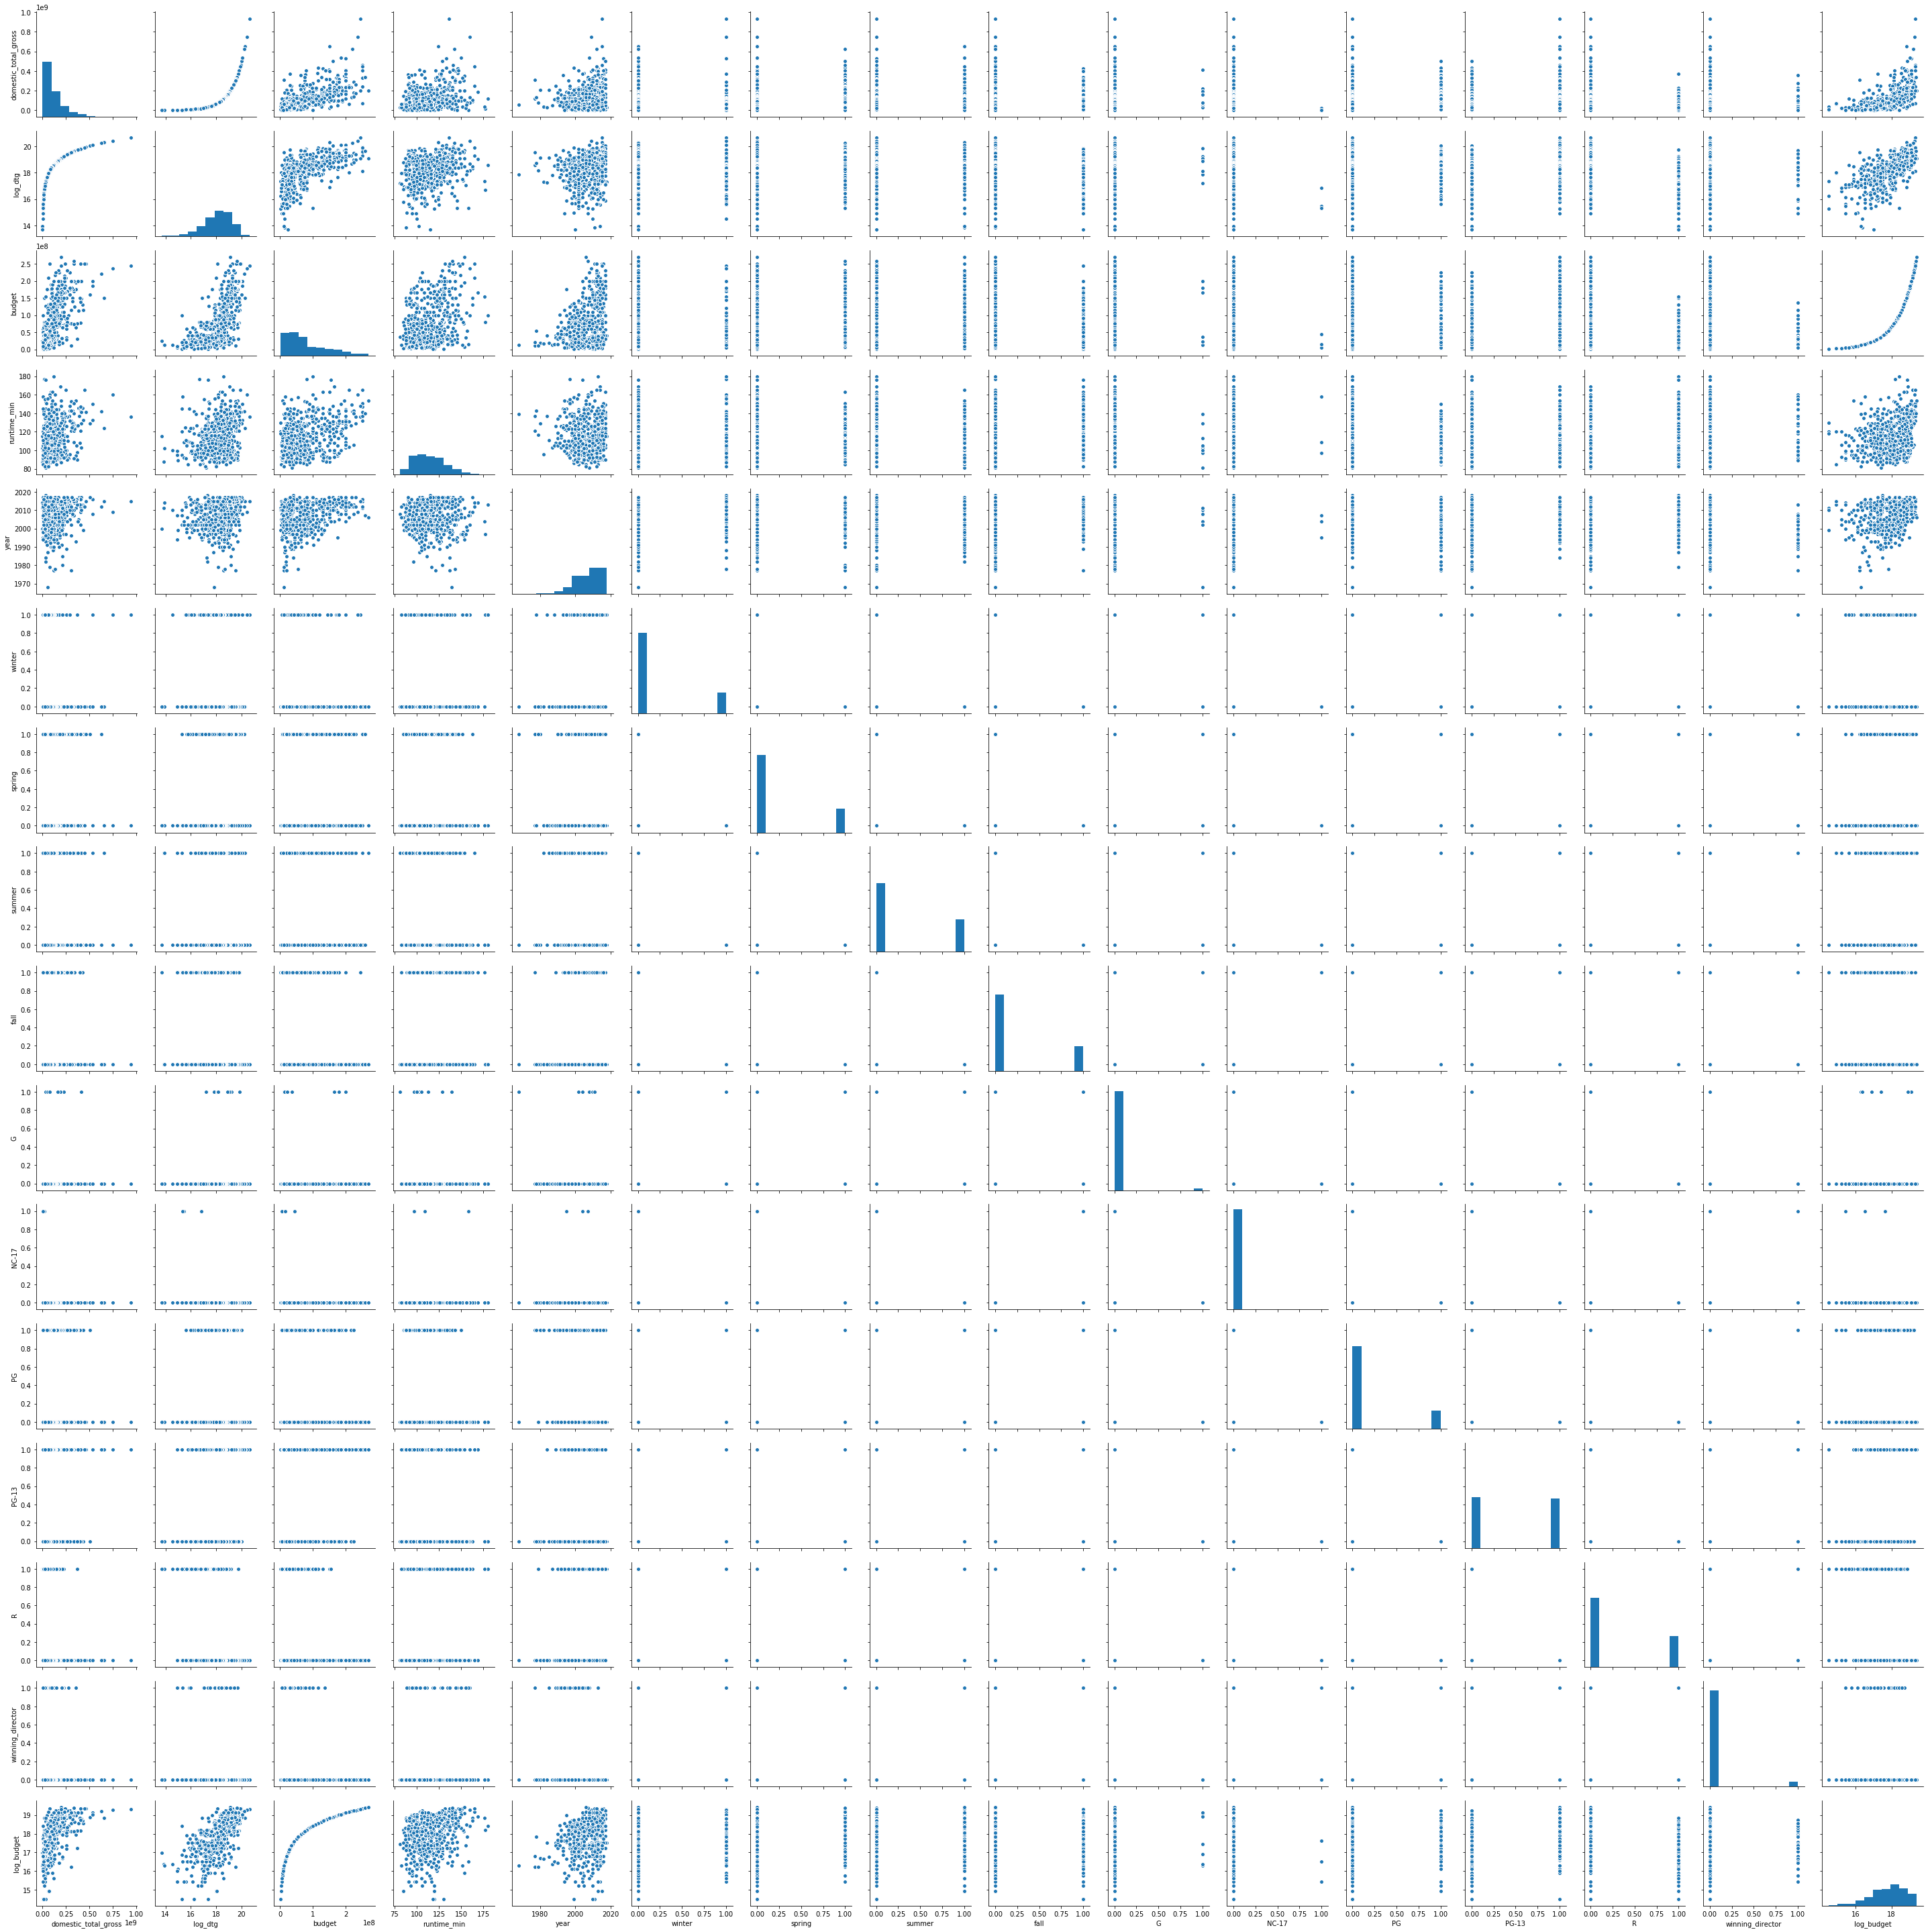

In [10]:
# Look at pairplot
sns.pairplot(data)

# Plot features vs. target variable

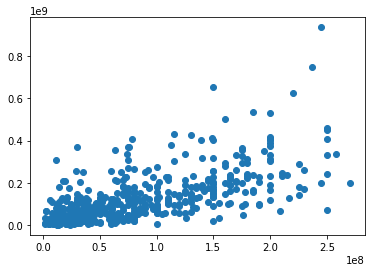

In [11]:
# Budget vs. Domestic Total Gross
plt.scatter(data.budget, data.domestic_total_gross)

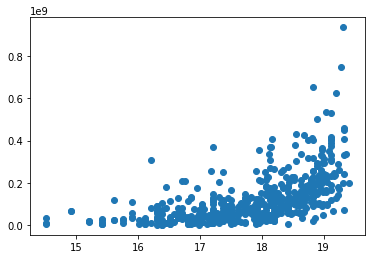

In [12]:
# Log Budget vs. Domestic Total Gross
plt.scatter(data.log_budget, data.domestic_total_gross)

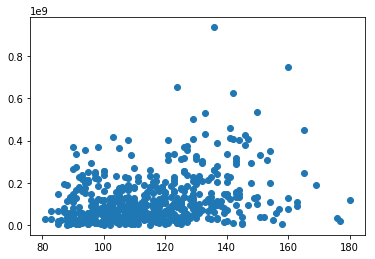

In [13]:
# Runtime vs. Domestic Total Gross
plt.scatter(data.runtime_min, data.domestic_total_gross)

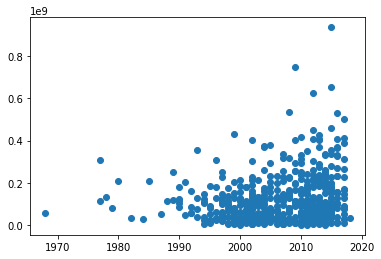

In [14]:
# Year vs. Domestic Total Gross
plt.scatter(data.year, data.domestic_total_gross)

In [15]:
data.columns

Index(['domestic_total_gross', 'log_dtg', 'budget', 'runtime_min', 'year',
       'winter', 'spring', 'summer', 'fall', 'G', 'NC-17', 'PG', 'PG-13', 'R',
       'winning_director', 'log_budget', 'release_date', 'title', 'director',
       'genre'],
      dtype='object')

# Plot features vs. log of target variable

In [16]:
# Log target variable
data['log_dtg'] = np.log(data.domestic_total_gross)

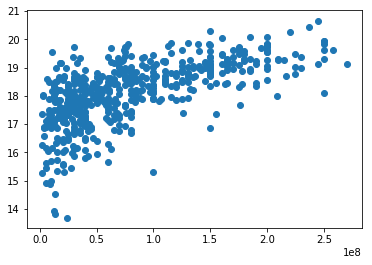

In [17]:
# Budget vs. Log of Domestic Total Gross
plt.scatter(data.budget, data.log_dtg)

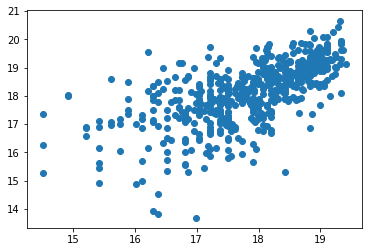

In [18]:
# Log Budget vs. Log of Domestic Total Gross
plt.scatter(data.log_budget, data.log_dtg)

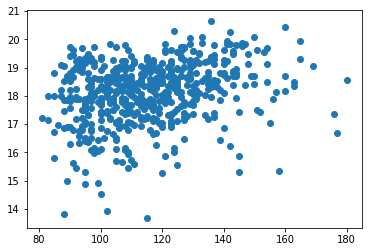

In [19]:
# Runtime vs. Log of Domestic Total Gross
plt.scatter(data.runtime_min, data.log_dtg)

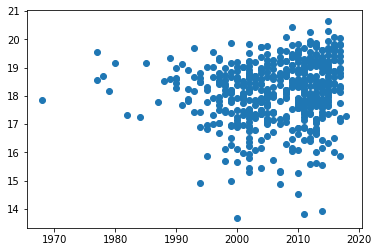

In [20]:
# Year vs. Log of Domestic Total Gross
plt.scatter(data.year, data.log_dtg)

In [21]:
# Reorder columns for linear regression
data = data[['domestic_total_gross',
             'log_dtg',
             'budget',
             'runtime_min',
             'year',
             'winter',
             'spring',
             'summer',
             'fall',
             'G',
             'NC-17',
             'PG',
             'PG-13',
             'R',
             'winning_director',
             'log_budget',
             'release_date',
             'title',
             'director',
             'genre'
            ]]

In [22]:
data.tail()

,domestic_total_gross,log_dtg,budget,runtime_min,year,winter,spring,summer,fall,G,NC-17,PG,PG-13,R,winning_director,log_budget,release_date,title,director,genre
535,63946815.0,17.973562,35000000.0,102.0,2005,0,0,1,0,0,0,1,0,0,0,17.370859,2005-07-29,Sky High,Mike Mitchell,['superhero']
536,46704056.0,17.659342,35000000.0,108.0,1991,0,0,1,0,0,0,1,0,0,0,17.370859,1991-06-21,The Rocketeer,Joe Johnston,['superhero']
537,46464023.0,17.654189,75000000.0,126.0,2005,0,0,0,1,0,0,1,0,0,0,18.132999,2005-10-28,The Legend of Zorro,Martin Campbell,['superhero']
538,28795985.0,17.175747,28000000.0,103.0,2013,0,0,1,0,0,0,0,0,1,0,17.147715,2013-08-16,Kick-Ass 2,Jeff Wadlow,['superhero']
539,24409722.0,17.010492,43000000.0,97.0,2005,1,0,0,0,0,0,0,1,0,0,17.576711,2005-01-14,Elektra,Rob Bowman,['superhero']


### Create train and hold-out test set

In [23]:
# Choose features and target to be X, y
X = data.iloc[:,2:16]
y = data.iloc[:,0:2]

In [24]:
# Split the data into training and hold-out test sets
X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(X, y, test_size=0.2, random_state=156)

# Model 1: All features, target = domestic_total_gross

In [25]:
# 5-fold cross-validation for linear regression
lr_1 = LinearRegression()

# Choose the predictor variable: domestic_total_gross (first column)
X_1 = X_train.iloc[:,:13]

# Choose the response variables
y_1 = y_train.iloc[:,0]

# Evaluate the model using r2 --> explained variance
scores_1 = cross_val_score(lr_1, X_1, y_1, cv=5, scoring='r2')
print(scores_1)

[0.54193309 0.23330567 0.41069966 0.50602487 0.34424284]


In [26]:
# Use average r2 as an estimate of out-of-sample r2
print(scores_1.mean())

0.4072412267143785


# Model 2: Logged budget and logged domestic total gross

In [27]:
# 5-fold cross-validation for linear regression
lr_2 = LinearRegression()

# Choose the predictor variable: domestic_total_gross (first column)
X_2 = X_train.iloc[:,1:14]

# Choose the response variables
y_2 = y_train.iloc[:,1]

# Evaluate the model using r2 --> explained variance
scores_2 = cross_val_score(lr_2, X_2, y_2, cv=5, scoring='r2')
print(scores_2)

[0.50862317 0.42520275 0.38708455 0.43017447 0.30350393]


In [28]:
# Use average r2 as an estimate of out-of-sample r2
print(scores_2.mean())

0.410917775906101


# Parameter grid-search for Lasso

### Baseline Lasso

In [29]:
# Run Lasso with guessed alpha parameter
lasso = Lasso(alpha=0.01, normalize=False)

# Fit model
lasso.fit(X_2, y_2)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
# Transform test data for Model 2 (log budget and dtg)
X_2_test = X_holdout_test.iloc[:,1:14]
y_2_test = y_holdout_test.iloc[:,1]

# Calculate r2 on train data
print('Train score:', lasso.score(X_2, y_2))

# Calculate r2 on test data
print('Test score:', lasso.score(X_2_test, y_2_test))

Train score: 0.4347635895948029
Test score: 0.6154614673248767


### Initial paramater search, orders of magnitude

In [31]:
# Define the parameter values that should be searched
alpha_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 100, 1000, 10000, 100000]
normalize_range = [True, False]
print(alpha_range, normalize_range)

[0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000] [True, False]


In [32]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(alpha=alpha_range, normalize=normalize_range)
print(param_grid)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000], 'normalize': [True, False]}


In [33]:
# Instantiate the grid
grid = GridSearchCV(Lasso(), param_grid, cv=5)
grid.fit(X_2, y_2)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
# View the complete results (list of named tuples)
#grid.grid_scores_

In [35]:
# Get best parameters
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

Best parameters set found on development set:

{'alpha': 0.001, 'normalize': True}


### Tiling in on alpha parameter, magnitude = 0.001

In [36]:
# Define the parameter values that should be searched
alpha_range_2 = [1.7e-3, 1.6e-3, 1.5e-3, 1.4e-3, 1.3e-3, 1.2e-3, 1.1e-3, 1e-3, 9.9e-4, 9.8e-4, 9.7e-4, 9.6e-4, 9.5e-4]
normalize_range = [True, False]
print(alpha_range_2, normalize_range)

[0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.001, 0.00099, 0.00098, 0.00097, 0.00096, 0.00095] [True, False]


In [37]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid_2 = dict(alpha=alpha_range_2, normalize=normalize_range)
print(param_grid_2)

{'alpha': [0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.001, 0.00099, 0.00098, 0.00097, 0.00096, 0.00095], 'normalize': [True, False]}


In [38]:
# Instantiate the grid
grid_2 = GridSearchCV(Lasso(), param_grid_2, cv=5)
grid_2.fit(X_2, y_2)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.001, 0.00099, 0.00098, 0.00097, 0.00096, 0.00095], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
# Get best parameters
print("Best parameters set found on development set:")
print()
print(grid_2.best_params_)

Best parameters set found on development set:

{'alpha': 0.00097, 'normalize': True}


### Run Lasso with optimized parameters

In [40]:
# Instantiate model
lasso_2 = Lasso(alpha=0.00097, normalize=True)

#Fit model
lasso_2.fit(X_2, y_2)

Lasso(alpha=0.00097, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
# View coefficients and intercept
print('Coefficients:', lasso_2.coef_)
print()
print('Intercept:', lasso_2.intercept_)

Coefficients: [ 0.00948581 -0.         -0.17749851  0.          0.03296514 -0.30991815
  0.03713802 -1.26214376  0.21625468  0.         -0.36357888  0.03407606
  0.50284759]

Intercept: 8.221271538934282


In [42]:
# View each feature and its coefficient
for feature, coef in zip(X_2.columns, lasso_2.coef_):
    print(feature, coef)

runtime_min 0.009485808467197909
year -0.0
winter -0.17749850757533733
spring 0.0
summer 0.03296513681728848
fall -0.309918145379115
G 0.03713802151813969
NC-17 -1.2621437581983144
PG 0.21625467913983637
PG-13 0.0
R -0.3635788798598379
winning_director 0.034076057014303815
log_budget 0.5028475863635042


In [43]:
# Calculate r2 on train data
print('Optimized Lasso Train R-squared:', lasso_2.score(X_2, y_2))

# Calculate r2 on test data
print('Optimized Lasso Test R-squared:', lasso_2.score(X_2_test, y_2_test))

Optimized Lasso Train R-squared: 0.44735297639261085
Optimized Lasso Test R-squared: 0.6091051507465588


# Final predictions and RMSE

In [44]:
# Predict
y_preds = lasso_2.predict(X_2_test)
#print(y_preds)

# Calculate RMSE
RMSE_lasso_2 = math.exp(np.sqrt(np.mean(np.sum(y_2_test - y_preds)**2)))
print(RMSE_lasso_2)

14850.394242931408


### Plot residuals

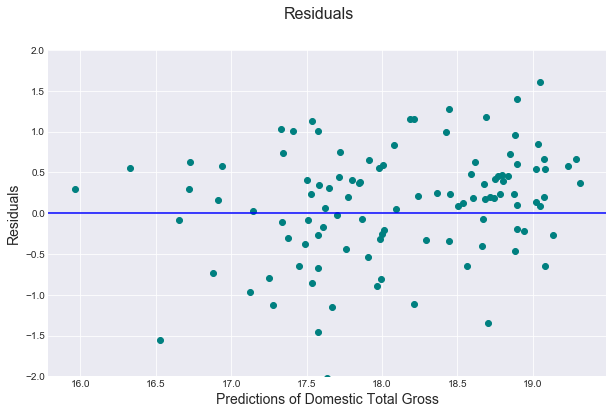

In [45]:
# Style plot
sns.set_style('darkgrid')

# Set size of plot
plt.figure(figsize=(10,6))

# Plot residuals and horizontal line
plt.scatter(y_preds, y_2_test-y_preds, color='teal')
plt.axhline(y=0, color='b', linestyle='-')

# Label plot
plt.suptitle('Residuals', fontsize=16)
plt.xlabel('Predictions of Domestic Total Gross', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.ylim([-2,2]);

### Plot predicted vs. actual

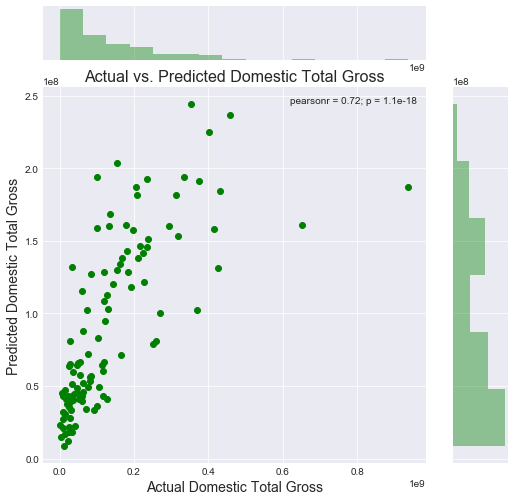

In [46]:
# Exponentiate predictions and actuals (because they were logged before)
y_2_test_norm = np.exp(y_2_test)
y_preds_norm = np.exp(y_preds)

# Plot predictions vs. actual
ax = sns.jointplot(y_2_test_norm, y_preds_norm, size=7, color='g', space=0.5)

# Label title and axes
ax.ax_joint.set_title('Actual vs. Predicted Domestic Total Gross', fontsize=16)
ax.set_axis_labels('Actual Domestic Total Gross', 'Predicted Domestic Total Gross', fontsize=14);

### Plot predictions and actual for log_budget feature

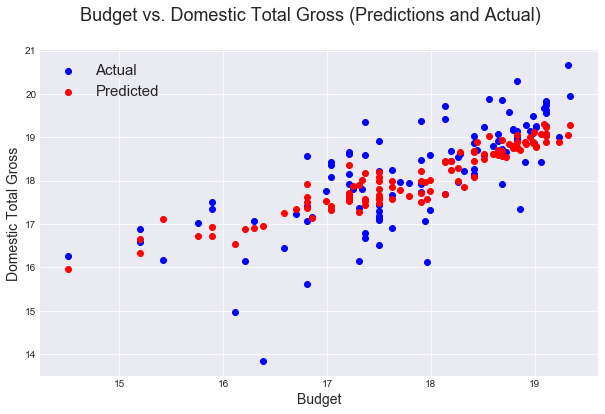

In [47]:
# Create plot
plt.figure(figsize=(10,6))
plt.scatter(X_2_test.log_budget, y_2_test, color='blue', label='Actual',)
plt.scatter(X_2_test.log_budget, y_preds, color='red', label='Predicted')

# Label title and axes
plt.suptitle('Budget vs. Domestic Total Gross (Predictions and Actual)', fontsize=18)
plt.xlabel('Budget', fontsize=14)
plt.ylabel('Domestic Total Gross', fontsize=14)
plt.legend(fontsize=15);

# Other models

In [48]:
# Create empty dict
models = {}

# Add linear models to dict
models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=0.00097, normalize=True)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber', max_iter=2000)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive', max_iter=2000)

# Add non-linear models to dict
models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()

# Create models and print R-squared results
for name, model in models.items():
    scores_all = model_selection.cross_val_score(model, X_2, y_2, n_jobs=1)
    print('Model:', name)
    print('Score:', str(np.mean(scores_all)))
    print()

Model: linear_model
Score: 0.4137598485593037

Model: ridge_model
Score: 0.4137983575839031

Model: lasso_model
Score: 0.416683698369185

Model: robust_regression
Score: -10443.264808198079

Model: eps_insensitive
Score: -605526.4419726575

Model: cart
Score: 0.02026154461567664

Model: extratrees
Score: 0.21250441411246054

Model: randomForest
Score: 0.3285841136051227

Model: adaboostedTrees
Score: 0.37901201691187475

Model: gradboostedTrees
Score: 0.3491668952130016

